# Implement blocks of GPT

In [2]:
import torch
import torch.nn as nn

In [3]:
torch.__version__

'2.6.0'

##  GPT Config

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

## DummyGPTModel

In [5]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    
    def forward(self,x):
        return x
    
 

## LayerNorm

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [7]:
import tiktoken

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort make you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626,  787,  345],
        [6109, 1110, 6622,  257]])


In [9]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape is ", logits.shape)
print(logits)

Output shape is  torch.Size([2, 4, 50257])
tensor([[[-0.7862,  0.2201, -0.4505,  ..., -0.9930, -0.1411, -0.2997],
         [-0.0788,  0.3002, -0.2933,  ...,  0.1582,  0.8911,  0.8224],
         [ 0.4067,  0.6476,  0.7205,  ..., -0.1623, -0.2637, -0.0259],
         [ 0.0636,  1.0565, -0.2506,  ...,  0.7537, -0.0750, -0.6892]],

        [[-0.7203,  0.1351, -0.6010,  ..., -1.0265,  0.1728, -0.2918],
         [-0.5934,  0.4450, -0.0059,  ...,  0.3412,  0.0572,  1.0979],
         [ 0.2673,  0.8401, -0.4473,  ..., -0.0181, -0.1089,  0.2539],
         [-0.1034, -0.5897, -0.3929,  ...,  1.4013, -0.3186,  0.1303]]],
       grad_fn=<UnsafeViewBackward0>)


In [10]:
torch.set_printoptions(sci_mode=False)

In [11]:
batch_example = torch.rand(2,5)

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("Var: ", var)

Mean:  tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Var:  tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


## GELU

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3)))
        )

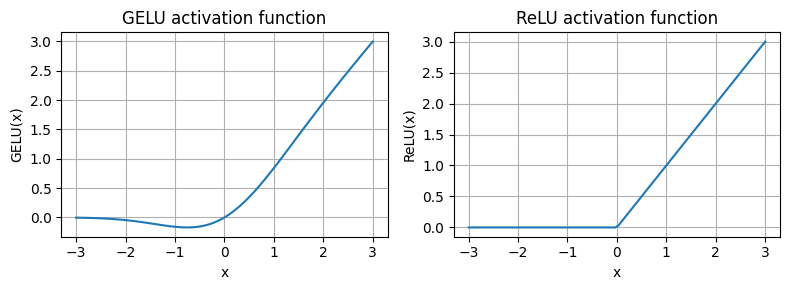

In [14]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

## FeedForward

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self,x):
        return self.layers(x)

In [16]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Shortcut Connections

In [17]:
class ExampleNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                                    GELU()),
        ])
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [18]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleNeuralNetwork(layer_sizes, use_shortcut=False)

In [19]:
def print_gradients(model, x):
    output = model(x)
    target = torch.zeros_like(output)

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [20]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [21]:
torch.manual_seed(123)
model_with_shortcut = ExampleNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## Transformer

In [22]:
from previous_chapters import MultiHeadAttention

In [37]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [38]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# Simple GPT Architecture

In [33]:
# Implementation of Simple GPT Architecture

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    